## Домашнее задание
### Практическая часть
**1. Построение графа Де Брюина** (5 баллов)  
По заданному набору ридов в формате FASTQ и параметру
k, который соответствует длине k-меров, построить
граф Де Брюина, некоторый путь в котором соответствовал
бы возможной подстроке в исходном геноме. Не забывайте
про запоминание покрытия каждого k-мера, а так же про
сами подстроки, которые соответствуют каждому ребру.
В остальном граф полностью соответствует тому, что
был описан в лекции.  

In [1]:
import random
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
class Node:
    def __init__(self, read):
        self.read = read
        self.in_deg = 0
        self.out_deg = 0
    def __str__(self):
        return f'vert {self.read} {self.in_deg} -> {self.out_deg}'
    def __repr__(self):
        return f'vert {self.read} {self.in_deg} -> {self.out_deg}'

class Edge:
    def __init__(self, v1, v2, read, cov=1):
        self.v1 = v1
        self.v2 = v2
        self.read = read
        self.cov = cov
    def __str__(self):
        return f'edge {self.v1} -> {self.v2} read {self.read}'
    def __repr__(self):
        return f'edge {self.v1} -> {self.v2} read {self.read}'

class DBGraph:

    def __init__(self, file, k, way):
        self.reads = self.get_reads(file) if not way == 'test' else file
        self.verts, self.edges = self.build_graph(k)

    def get_reads(self, file):
        with open(file, 'r') as f:
            fasta_lines = f.readlines()
        reads = []

        for line in fasta_lines:
            if line[0] != '>':
                reads.append(line.rstrip())

        return reads

    def build_graph(self, k):
        edges = dict()
        verts = dict()

        for read in self.reads:
            i = 0
            while i+k < len(read):
                v1 = read[i:i+k]
                v2 = read[i+1:i+k+1]
                if v1 in edges.keys():
                    edges[v1].append(Edge(v1, v2, v1 + v2[-1]))
                else:
                    verts[v1] = Node(v1)
                    edges[v1] = [Edge(v1, v2, v1 + v2[-1])]
                if not v2 in edges.keys():
                    verts[v2] = Node(v2)
                    edges[v2] = []
                verts[v1].out_deg += 1
                verts[v2].in_deg += 1
                i += 1

        return (verts, edges)

    def compact_graph(self):
        verts_to_compact = [v for v in self.verts.values() if v.out_deg > 1 or v.in_deg == 0]

        for start_vert in verts_to_compact:
            #print(start_vert)
            #self.plot_graph()
            new_edges = []
            if not self.verts.get(start_vert.read) is None:
                for new_edge in self.edges[start_vert.read].copy():
                    cur_vert = start_vert
                    cur_edge = new_edge
                    path = [cur_edge]
                    if not self.verts.get(cur_edge.v2) is None:
                        while self.verts[cur_edge.v2].out_deg == 1:
                            del self.edges[cur_edge.v1][0]
                            cur_edge = self.edges[cur_edge.v2][0]
                            path.append(cur_edge)
                            del self.verts[cur_edge.v1]
                            if self.verts[cur_edge.v2].out_deg != 1:
                                del self.edges[cur_edge.v1][0]
                        cur_vert = self.verts[cur_edge.v2]  #в конце остаемся в вершине в которую не идут ребра, но из которой или 0 или больше 1 ребра
                        if len(path) > 1:
                            new_edge_read = start_vert.read + ''.join([e.v2[-1] for e in path])
                            edge_len_sum = sum([len(e.read) for e in path])
                            new_edge_coverage = round(sum([len(e.read) * e.cov for e in path]) / edge_len_sum)
                            new_edge = Edge(start_vert.read, cur_vert.read, new_edge_read, new_edge_coverage)
                        new_edges.append(new_edge)
                self.edges[start_vert.read] = new_edges


    def plot_graph(self, width=1000, height=1000):
        all_edges = []
        edges_names = dict()
        for x in self.edges.values():
            for e in x:
                all_edges.append([e.v1, e.v2])
                edges_names[(e.v1, e.v2)] = e.read
        G = nx.DiGraph(directed=True)
        G.add_edges_from(all_edges)
        pos = nx.spring_layout(G)
        plt.figure(figsize=(20, 15))
        nx.draw(
            G, pos, edge_color='black', width=1, linewidths=1,
            node_size=700, node_color='pink', alpha=0.9,
            labels={node: node for node in G.nodes()}
        )
        nx.draw_networkx_edge_labels(
            G, pos,
            edge_labels=edges_names,
            font_color='red'
        )
        plt.axis('off')
        plt.show()

In [3]:
def random_sequence(seqlen):
    return "".join([random.choice("ACGT") for i in range(seqlen)])

['CTCGCAGGCT']


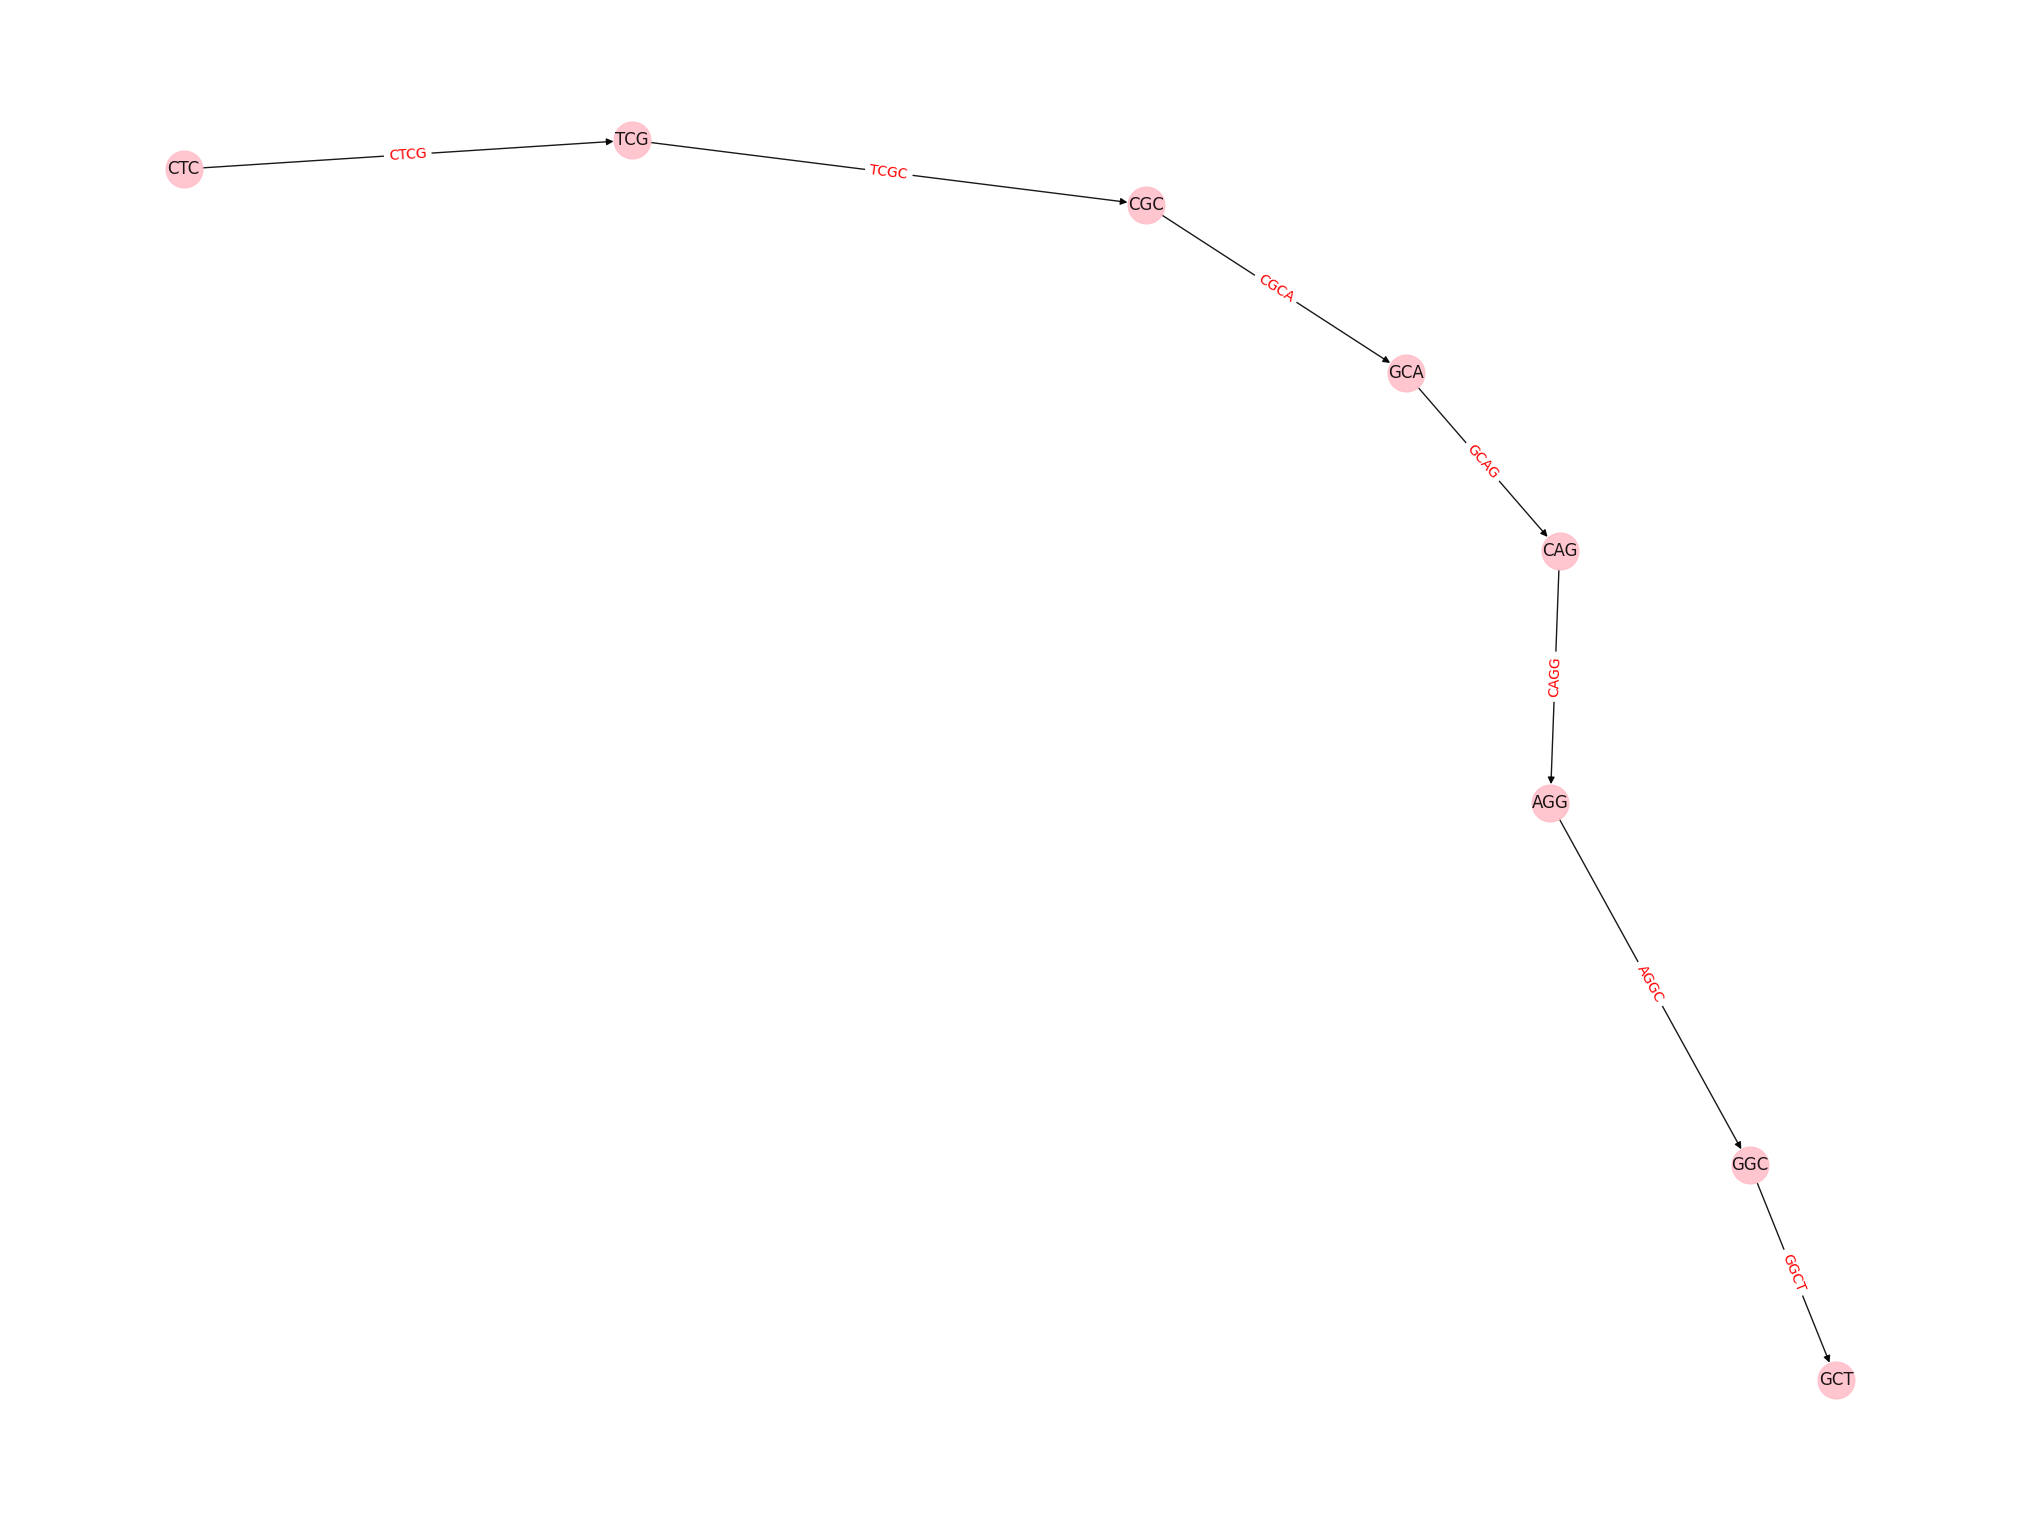

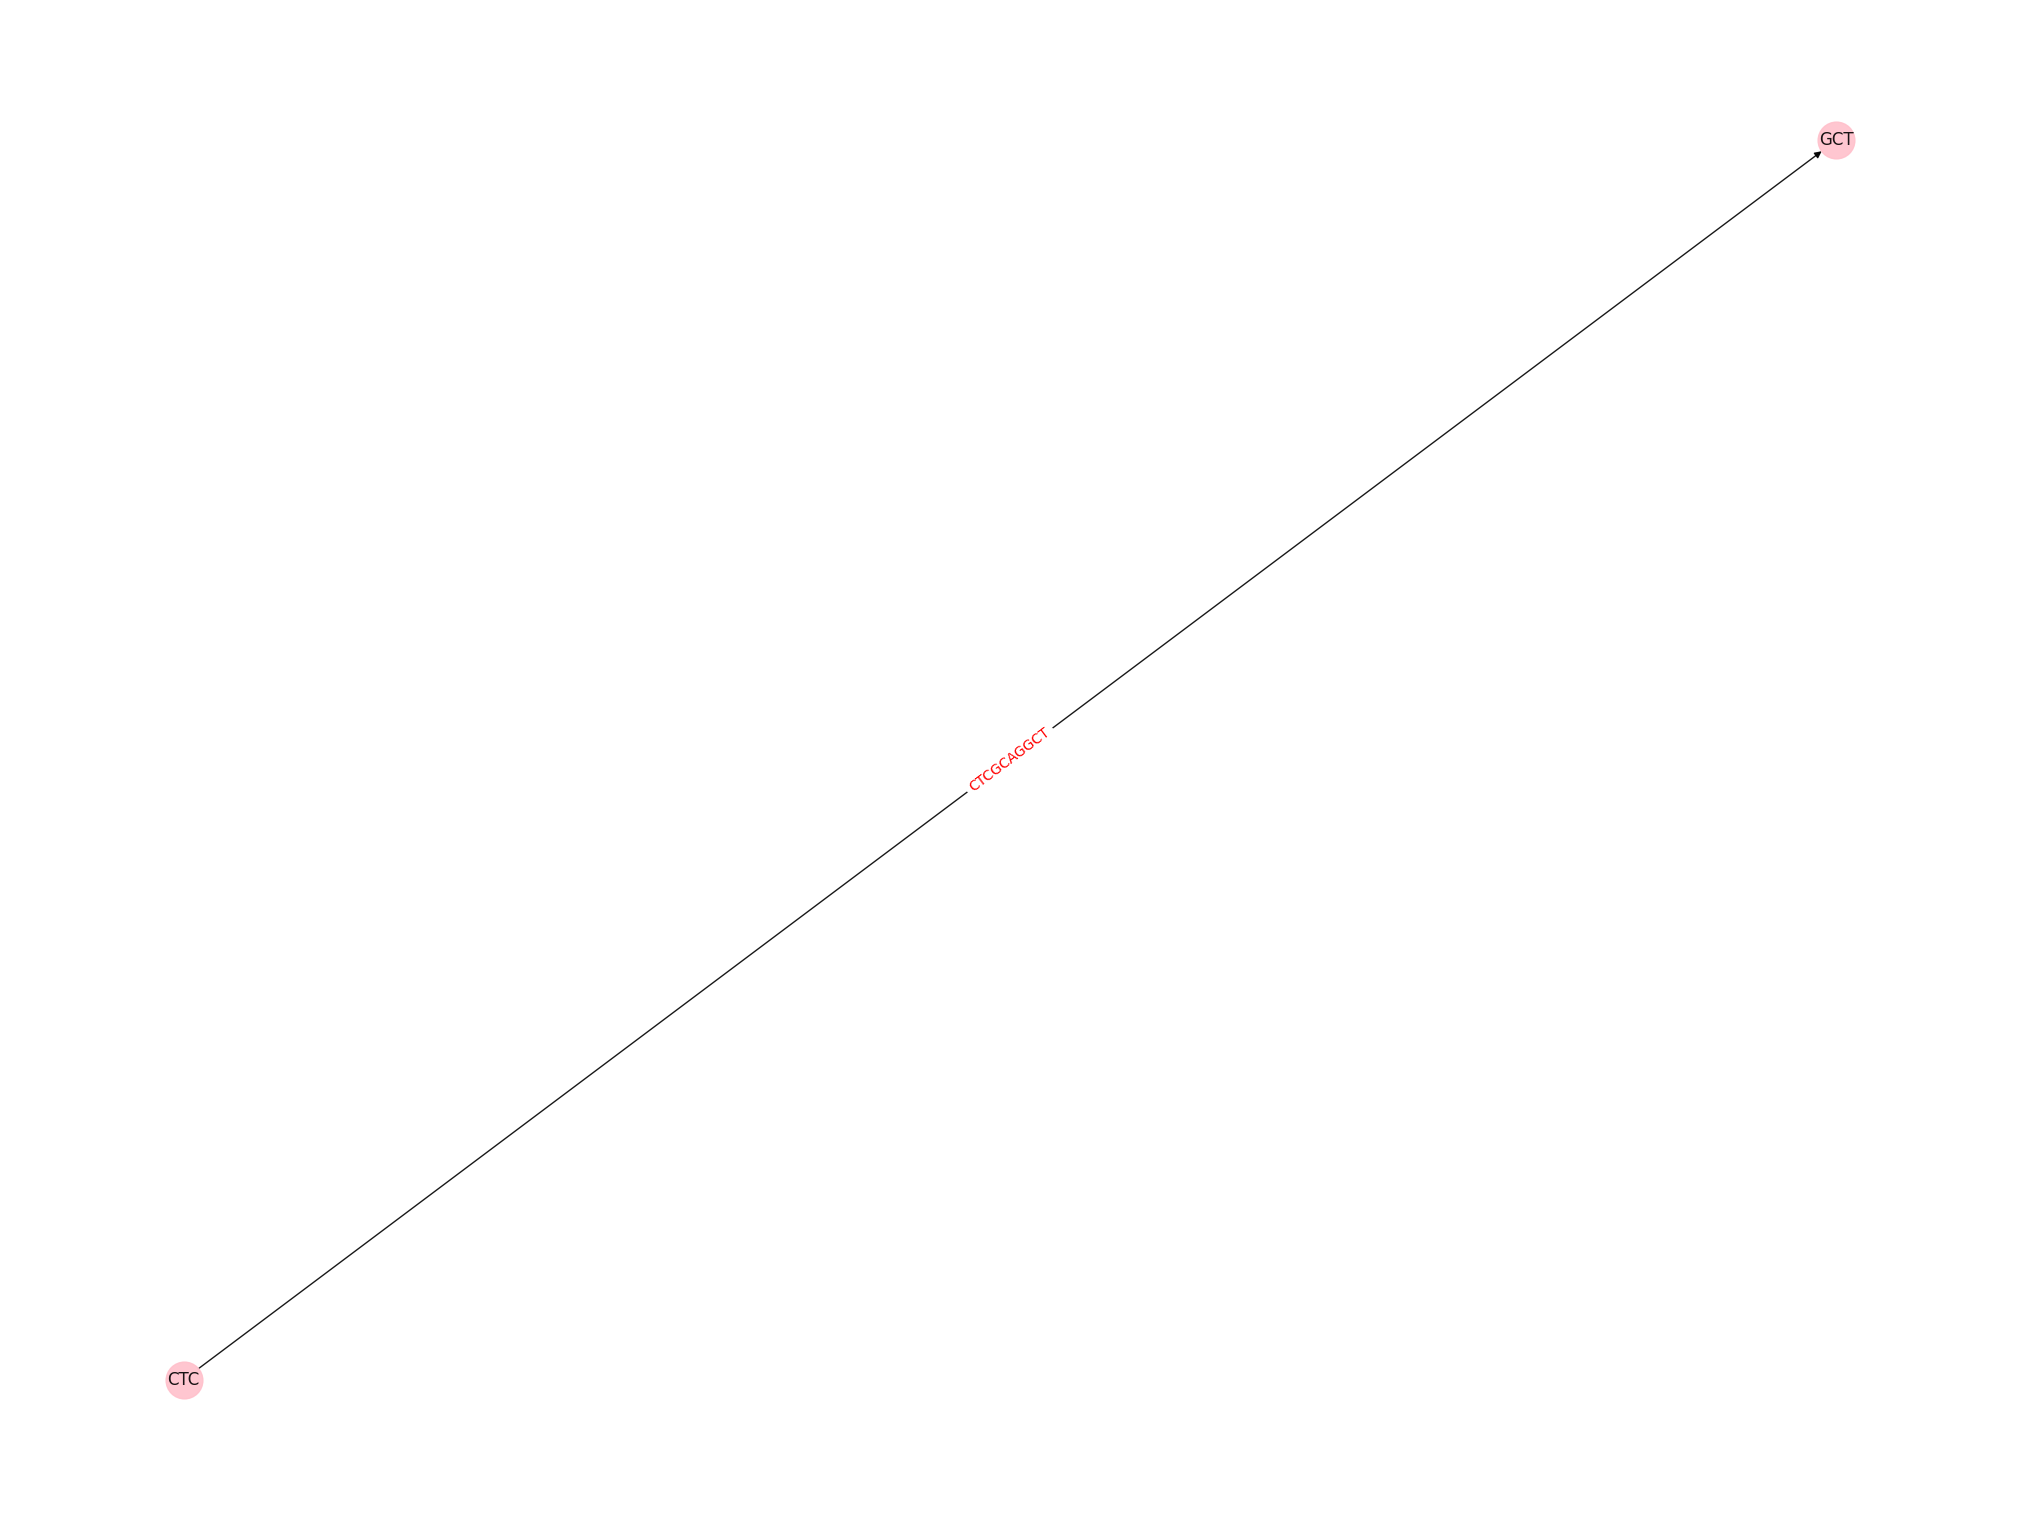

In [4]:
test_sequence = [random_sequence(10)]
print(test_sequence)

g = DBGraph(test_sequence, 3, 'test')
g.plot_graph()
g.compact_graph()
g.plot_graph()


**2. Сжатие графа** (4 балла)  
Научитесь производить сжатие графа Де Брюина. При
сжатии не забывайте склеивать подстроки на ребрах и
обновлять покрытие ребер. Пересчитывайте покрытие
склеиваемых ребер как взвешенное среднее, где вес
соответствует длине подстроки, соответствующей ребру.  
**3. Удаление хвостов** (3 балла)  
Реализуйте возможность после построения графа удалять
плохо покрытые хвосты. Чтобы определить, является ли
хвост плохо покрытым, нужно посчитать распределение
произведений покрытий на длину хвоста по всем хвостам
и удалить те, что попадают в 30 процентов ближе к
нулю распределения.  
**4. Удаление пузырей** (4 балла)  
Научитесь удалять такие пузыри в графе, длина
которых меньше либо равна 2k. Таким образом должно
получится удаление последствий единичных ошибок в
ридах.  
  
**5. Анализ графа после упрощений** (4 балла)  
Постройте граф на основе ридов представленных по
ссылке ниже. Сохраните граф до всех упрощений и
после, посчитайте распределения степеней вершин
и покрытий ребер, постройте графики. Так же сравните
на сколько уменьшается количество вершин и ребер.

**6. Найти контиги** (дополнительные 4 балла)
Разбейте построенный и упрощенный граф на
непересекающиеся пути, которым однозначно
соответствует подстрока в геноме. Найдите эти
подстроки, попробуйте три самых длинных найти,
используя [blast](https://blast.ncbi.nlm.nih.gov/Blast.cgi)
Напишите, что нашлось.


Для того чтобы тестировать Ваш код, используйте
синтетические данные без ошибок. Можете просто
сгенерировать большую случайную строку длины 1000
и из нее набрать подстроки длины 150. Считайте при
записи в FASTQ, что качество таких ридов наилучшее.  
Финальная версия алгоритма построения графа должна
работать на данных секвенирования кишечной палочки
([ссылка](https://trace.ncbi.nlm.nih.gov/Traces/sra/?run=ERR008613))  
Задания 3...6 будут засчитываться при работе
алгоритма именно на этих данных. Учтите, чтобы решение
работало на них, вам нужно аккуратно
относиться к памяти и производительности, кроме того,
обязательно делайте предобработку данных, используйте
тулы из задания 2.1, в том числе trimmomatic.
